# K-Means Clustering Analysis of Airbnb Data

This notebook performs K-means clustering analysis on Airbnb listing data to identify distinct groups of listings with similar characteristics.

## Setup and Data Loading

First, we import the necessary libraries for data manipulation, clustering, visualization and analysis:

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
from IPython.display import display

Load the cleaned Airbnb dataset:

In [5]:
df = pd.read_csv("../ML-Exam/data/cleaned_airbnb_data.csv")

## Finding Optimal Number of Clusters

We use the elbow method to determine the optimal number of clusters. This involves:
1. Selecting and standardizing numerical features
2. Running K-means with different k values
3. Calculating the inertia (within-cluster sum of squares)
4. Finding the 'elbow point' where adding more clusters gives diminishing returns

We also calculate the percentage improvement between successive k values to make the decision more objective.

Improvement percentages for each additional cluster:
  k=2: 14.84% improvement
  k=3: 10.64% improvement
  k=4: 10.14% improvement
  k=5: 10.51% improvement
  --> Last value above 10% threshold
  k=6: 9.14% improvement
  k=7: 5.71% improvement
  k=8: 4.79% improvement
  k=9: 5.16% improvement
  k=10: 4.57% improvement


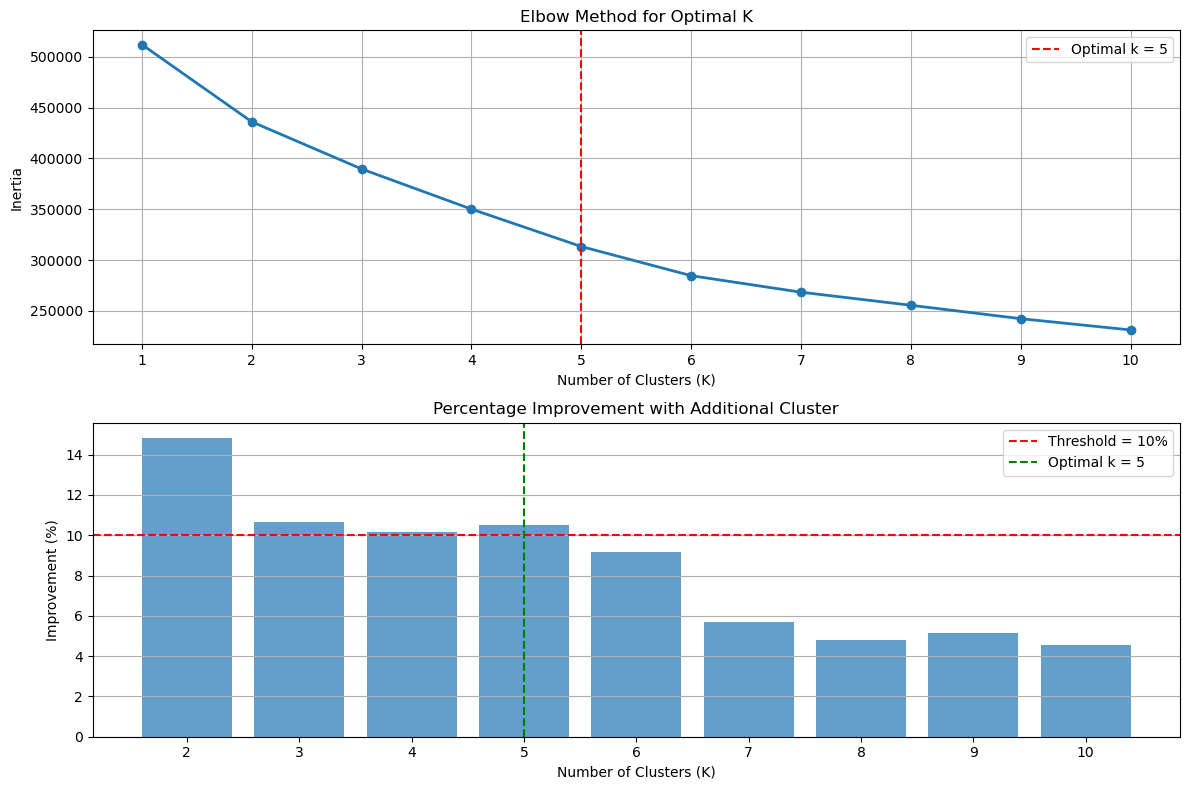

Automatically determined optimal k = 5 (last cluster with improvement >= 10%)


In [7]:
# Select numerical features for clustering
numerical_features = ['realSum', 'person_capacity', 'cleanliness_rating', 
                      'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist',
                      'host_is_superhost_bool', 'Is_weekend_bool','room_private_bool']

# Create a copy of the data with just numerical features
cluster_data = df[numerical_features].copy()

# Standardize the data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# Determine optimal number of clusters using elbow method
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Find the elbow point using the rate of change
inertia_array = np.array(inertia)
# Calculate percentage of change in inertia
inertia_diffs = np.diff(inertia_array) / inertia_array[:-1] * 100
# Convert to absolute values (since changes are negative)
inertia_diffs_abs = np.abs(inertia_diffs)

# Find the last k value where improvement is above the threshold
threshold = 10  # percentage improvement threshold
optimal_k = 2  # default to 2 if no clear elbow

# Identify the last k value where the improvement is above threshold
last_above_threshold = None
for i, diff_pct in enumerate(inertia_diffs_abs):
    k_value = i + 2  # k value is i+2 (since we're looking at differences and k starts at 1)
    if diff_pct >= threshold:
        last_above_threshold = k_value

# Set optimal_k to be the last k with improvement above threshold
if last_above_threshold is not None:
    optimal_k = last_above_threshold  # Use exactly the last k above threshold

# Print the actual improvement percentages for clarity
print("Improvement percentages for each additional cluster:")
for i, pct in enumerate(inertia_diffs_abs):
    k_val = i + 2  # k starts at 2 for diffs
    print(f"  k={k_val}: {pct:.2f}% improvement")
    if k_val == last_above_threshold:
        print(f"  --> Last value above {threshold}% threshold")

# Plot the elbow curve
plt.figure(figsize=(12, 8))

# Main plot - inertia
plt.subplot(2, 1, 1)
plt.plot(k_range, inertia, marker='o', linewidth=2)
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.legend()

# Secondary plot - percentage improvement
plt.subplot(2, 1, 2)
plt.bar(range(2, len(k_range) + 1), inertia_diffs_abs, alpha=0.7)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold = {threshold}%')
# Mark the optimal k
plt.axvline(x=optimal_k, color='green', linestyle='--', 
           label=f'Optimal k = {optimal_k}')
plt.title('Percentage Improvement with Additional Cluster')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Improvement (%)')
plt.xticks(range(2, len(k_range) + 1))
plt.grid(True, axis='y')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Automatically determined optimal k = {optimal_k} (last cluster with improvement >= {threshold}%)")

## Performing K-Means Clustering

Based on the elbow analysis, we choose k=5 clusters and fit the K-means model:

In [9]:
optimal_k = 5  # Update this based on your elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_data)

## Analyzing Cluster Distribution by City

Visualize how the clusters are distributed across different cities:

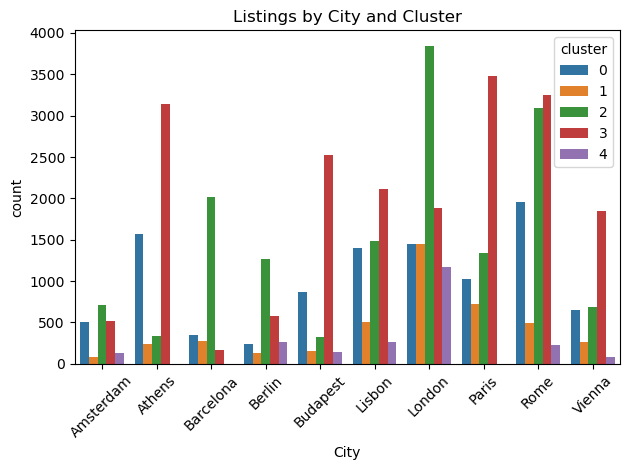

In [11]:
sns.countplot(data=df, x='City', hue='cluster')
plt.title("Listings by City and Cluster")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Examining Cluster Characteristics

Calculate and display summary statistics for each cluster:

In [13]:
cluster_summary = df.groupby('cluster')[numerical_features].mean()
cluster_summary
df['cluster'].value_counts().sort_index()

cluster
0    10018
1     4301
2    15105
3    19484
4     2281
Name: count, dtype: int64

## Detailed Cluster Analysis

Create a comprehensive visualization of cluster characteristics using:
1. A styled table showing cluster centers
2. A radar chart comparing different aspects of each cluster

,realSum,person_capacity,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,host_is_superhost_bool,Is_weekend_bool,room_private_bool
Cluster 0,399.900000,4.890000,9.540000,94.130000,2.060000,2.710000,0.570000,0.280000,0.490000,0.030000
Cluster 1,256.500000,2.940000,7.320000,73.180000,0.980000,3.340000,0.520000,0.010000,0.510000,0.420000
Cluster 2,195.310000,2.240000,9.570000,94.160000,1.000000,3.420000,0.570000,0.250000,0.500000,1.000000
Cluster 3,250.470000,3.050000,9.610000,94.750000,0.830000,2.550000,0.510000,0.310000,0.520000,0.000000
Cluster 4,189.760000,2.780000,9.470000,94.020000,1.160000,9.080000,3.730000,0.230000,0.520000,0.620000


Z-score normalized cluster means by feature group (scaled to [0,1] for visualization):


,Location,Accommodation,Quality,Price,Superhost
Cluster 0,0.360000,0.990000,0.620000,0.970000,0.640000
Cluster 1,0.400000,0.410000,0.000000,0.490000,0.010000
Cluster 2,0.410000,0.280000,0.620000,0.290000,0.590000
Cluster 3,0.340000,0.400000,0.640000,0.470000,0.720000
Cluster 4,1.000000,0.420000,0.620000,0.270000,0.540000


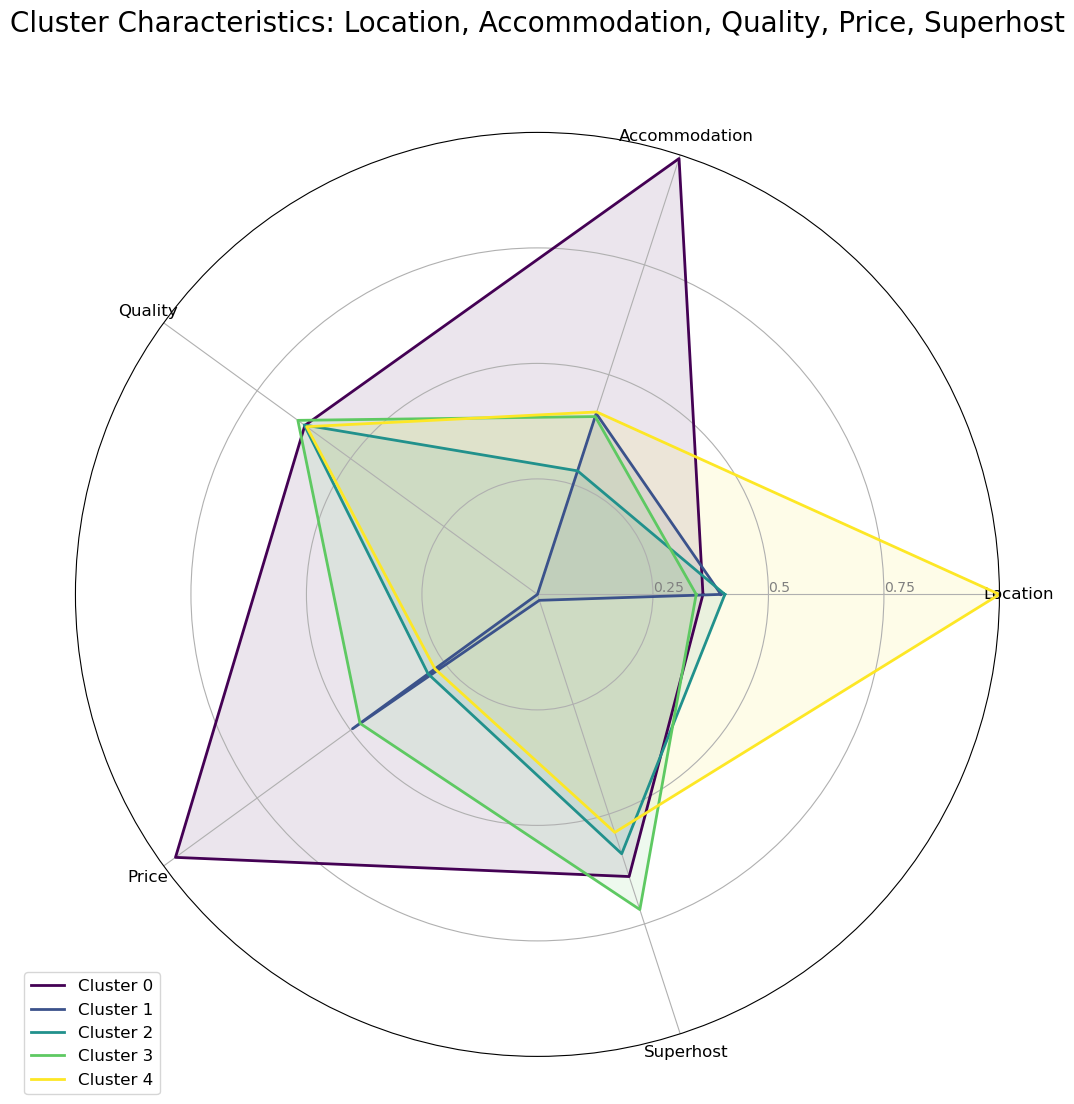

In [15]:
# Analyze the clusters
# Get the cluster centers and transform back to original scale
centers = kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers)

# Create a DataFrame with the cluster centers
centers_df = pd.DataFrame(centers_original, columns=numerical_features)
centers_df.index = [f'Cluster {i}' for i in range(optimal_k)]

# Display the cluster centers using a clean styled table with alternating row colors
centers_df_styled = centers_df.round(2).style.set_caption("Cluster Centers (Original Scale)")\
    .set_properties(**{
        'text-align': 'center',
        'color': 'black',
    })\
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-weight', 'bold'), ('font-size', '16px')]},
        {'selector': 'th', 'props': [
            ('text-align', 'center'), 
            ('background-color', '#d9d9d9'),
            ('color', 'black'),
            ('font-weight', 'bold')
        ]},
        {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},
        {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', 'white')]},
    ])

display(centers_df_styled)

# Visualize cluster characteristics with a radar chart
def radar_chart(df, title, colors=None):
    # Define feature groups
    feature_groups = {
        'Location': ['dist', 'metro_dist'],
        'Accommodation': ['bedrooms', 'person_capacity'],
        'Quality': ['cleanliness_rating', 'guest_satisfaction_overall'],
        'Price': ['realSum'],
        'Superhost': ['host_is_superhost_bool']
    }
    
    # Create a new DataFrame to store group averages
    group_df = pd.DataFrame(index=df.index)
    
    # Calculate the average for each feature group
    for group_name, features in feature_groups.items():
        valid_features = [f for f in features if f in df.columns]
        if valid_features:
            group_df[group_name] = df[valid_features].mean(axis=1)
    
    categories = list(group_df.columns)
    N = len(categories)
    
    # Normalize the data for the radar chart
    normalized_df = pd.DataFrame(index=group_df.index, columns=group_df.columns)
    
    for col in group_df.columns:
        feature_values = group_df[col].values
        normalized_values = stats.zscore(feature_values)
        normalized_df[col] = normalized_values
    
    # Scale to [0,1] range
    min_val = normalized_df.values.min()
    max_val = normalized_df.values.max()
    
    for col in normalized_df.columns:
        normalized_df[col] = (normalized_df[col] - min_val) / (max_val - min_val)
    
    print("Z-score normalized cluster means by feature group (scaled to [0,1] for visualization):")
    
    # Style the normalized values table
    norm_df_styled = normalized_df.round(2).style\
        .background_gradient(cmap='Blues')\
        .set_properties(**{
            'text-align': 'center',
            'font-weight': 'bold'
        })\
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('text-align', 'center'), 
                ('background-color', '#d9d9d9'),
                ('color', 'black'),
                ('font-weight', 'bold')
            ]},
        ])
    
    display(norm_df_styled)
    
    # Create the radar chart
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
    
    if colors is None:
        colors = plt.cm.viridis(np.linspace(0, 1, len(group_df.index)))
    
    for i, cluster in enumerate(group_df.index):
        values = normalized_df.loc[cluster, categories].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, label=cluster, color=colors[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])
    
    plt.xticks(angles[:-1], categories, size=12)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=10)
    plt.ylim(0, 1)
    
    plt.title(title, size=20, y=1.1)
    return fig, ax

# Create the radar chart
radar_chart(centers_df, "Cluster Characteristics: Location, Accommodation, Quality, Price, Superhost")
plt.show()

## Visualizing Clusters in 2D

Use PCA to reduce the dimensionality of our data to 2D for visualization. This helps us see how well-separated the clusters are:

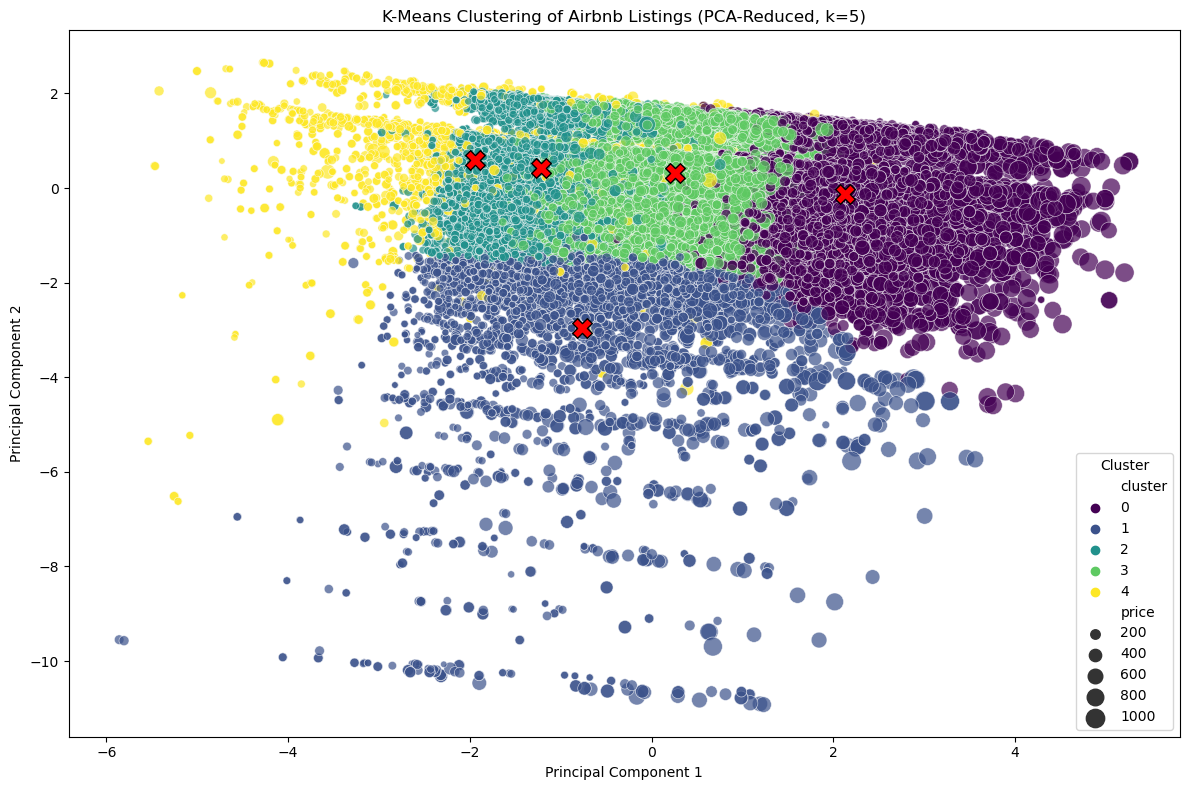

In [17]:
# Apply PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Create a dataframe with PCA results and cluster labels
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['cluster'] = df['cluster']
pca_df['price'] = df['realSum']

# Create the scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='cluster',
    size='price',
    sizes=(20, 200),
    palette='viridis',
    data=pca_df,
    alpha=0.7
)

# Add centers to the plot
centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=1, marker='X', edgecolor='black')

plt.title(f'K-Means Clustering of Airbnb Listings (PCA-Reduced, k={optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

## Save Clustered Data

Save the data with cluster assignments for future use, removing any old cluster columns:

In [19]:
df = df.drop(columns=['cluster_4', 'cluster_6'], errors='ignore')  # `errors='ignore'` makes it safe if they don't exist
df.to_csv("../ML-exam/data/clustered_airbnb.csv", index=False)